## Transfer learning model (Bonuspoint)

In [2]:
import keras
import logging
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [3]:
# set the directory based on the folder where you saved dataset
train_data_dir = 'C:/Users/Yasmin Lin/OneDrive/M DSS/Block 3/Deep Learning/Assignment/seg_train/seg_train' 
test_data_dir = 'C:/Users/Yasmin Lin/OneDrive/M DSS/Block 3/Deep Learning/Assignment/seg_test/seg_test'
image_generator = ImageDataGenerator(validation_split=0.2)    

train_data = image_generator.flow_from_directory(batch_size=64,
                                                 directory=train_data_dir,
                                                 shuffle=True,
                                                 target_size=(64,64), 
                                                 subset="training",
                                                 class_mode='categorical')

val_data = image_generator.flow_from_directory(batch_size=64,
                                                 directory=train_data_dir,
                                                 shuffle=False,
                                                 target_size=(64,64), 
                                                 subset="validation",
                                                 class_mode='categorical')
test_gen = ImageDataGenerator()
test_data = test_gen.flow_from_directory(test_data_dir,
                                       target_size=(64,64), batch_size=64, shuffle=False)


print(train_data.classes)
print(val_data.classes)
print(train_data.class_indices)
print(test_data.classes)
class_names = np.unique(train_data.classes)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
[0 0 0 ... 5 5 5]


In [4]:
# data augmentation
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip(mode='horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

In [5]:
#build transfer learning function
def transfer_model(image_shape=(64,64), data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                   include_top=False, # not include the 3 FC layers at the top of the network.
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = tf.keras.applications.vgg16.preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Flatten()(x)
    
    # add FC layers
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    outputs = tf.keras.layers.Dense(6,activation='softmax')(x)

    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [6]:
# build the transfer learning model
trans_model = transfer_model()
trans_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                             

In [7]:
# compile and fit the transfer learning model
trans_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
trans_history = trans_model.fit(train_data, epochs=10, batch_size=32, validation_data=val_data)

Epoch 1/10
176/176 [==============================] - 261s 1s/step - loss: 1.2972 - accuracy: 0.6829 - val_loss: 0.6079 - val_accuracy: 0.7924
Epoch 2/10
176/176 [==============================] - 232s 1s/step - loss: 0.6532 - accuracy: 0.7694 - val_loss: 0.5489 - val_accuracy: 0.8071
Epoch 3/10
176/176 [==============================] - 233s 1s/step - loss: 0.5828 - accuracy: 0.7923 - val_loss: 0.5011 - val_accuracy: 0.8256
Epoch 4/10
176/176 [==============================] - 174s 990ms/step - loss: 0.5254 - accuracy: 0.8117 - val_loss: 0.5127 - val_accuracy: 0.8292
Epoch 5/10
176/176 [==============================] - 175s 994ms/step - loss: 0.4911 - accuracy: 0.8215 - val_loss: 0.4894 - val_accuracy: 0.8374
Epoch 6/10
176/176 [==============================] - 173s 986ms/step - loss: 0.4621 - accuracy: 0.8354 - val_loss: 0.4541 - val_accuracy: 0.8424
Epoch 7/10
176/176 [==============================] - 169s 959ms/step - loss: 0.4500 - accuracy: 0.8380 - val_loss: 0.4352 - val_accu

In [8]:
test_loss, test_acc = trans_model.evaluate(test_data,batch_size=32)

47/47 [==============================] - 34s 717ms/step - loss: 0.4440 - accuracy: 0.8517


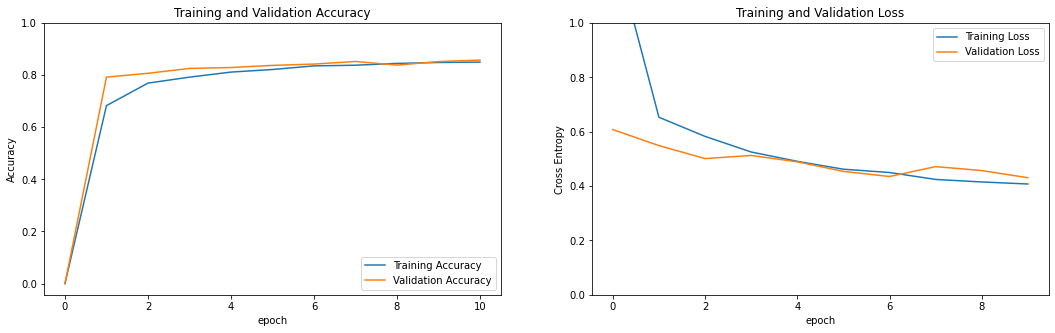

In [9]:
acc = [0.] + trans_history.history['accuracy']
val_acc = [0.] + trans_history.history['val_accuracy']

loss = trans_history.history['loss']
val_loss = trans_history.history['val_loss']

plt.figure(figsize=(18, 5))

plt.subplot(1,2,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [10]:
'''Fine-tuning'''
base_model = trans_model.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 16

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a CategoricalCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)


trans_model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=['accuracy'])

Number of layers in the base model:  19


In [11]:
fine_tune_epochs = 5
total_epochs =  10 + fine_tune_epochs

history_fine = trans_model.fit(train_data,
                               epochs=total_epochs,
                               initial_epoch=trans_history.epoch[-1],
                               validation_data=val_data)

Epoch 10/15


C:\Users\Yasmin Lin\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


176/176 [==============================] - 212s 1s/step - loss: 0.4643 - accuracy: 0.8362 - val_loss: 0.4291 - val_accuracy: 0.8570
Epoch 11/15
176/176 [==============================] - 220s 1s/step - loss: 0.3893 - accuracy: 0.8652 - val_loss: 0.4405 - val_accuracy: 0.8631
Epoch 12/15
176/176 [==============================] - 198s 1s/step - loss: 0.3517 - accuracy: 0.8720 - val_loss: 0.4148 - val_accuracy: 0.8741
Epoch 13/15
176/176 [==============================] - 206s 1s/step - loss: 0.3262 - accuracy: 0.8850 - val_loss: 0.3742 - val_accuracy: 0.8855
Epoch 14/15
176/176 [==============================] - 205s 1s/step - loss: 0.2986 - accuracy: 0.8915 - val_loss: 0.3851 - val_accuracy: 0.8812
Epoch 15/15
176/176 [==============================] - 209s 1s/step - loss: 0.2752 - accuracy: 0.8985 - val_loss: 0.3595 - val_accuracy: 0.8837


In [12]:
test_loss, test_acc = trans_model.evaluate(test_data,batch_size=32)

47/47 [==============================] - 32s 677ms/step - loss: 0.3490 - accuracy: 0.8730


In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

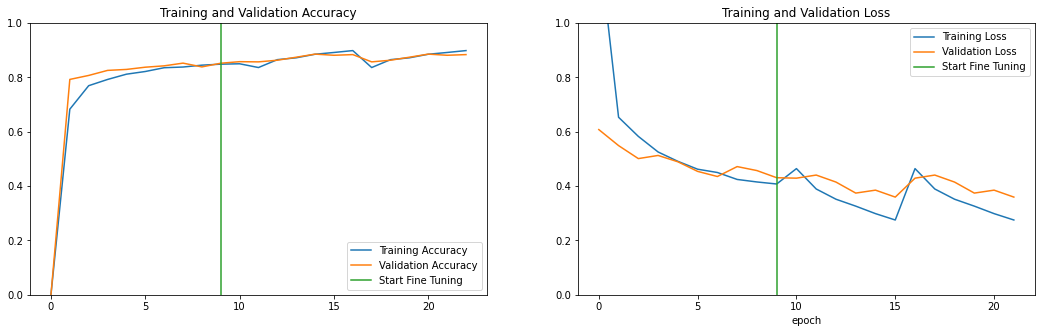

In [17]:
initial_epochs = 10

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
y_prediction = trans_model.predict(test_data)
y_pred = np.argmax(y_prediction, axis=1)
y_true = test_data.classes

47/47 [==============================] - 33s 704ms/step


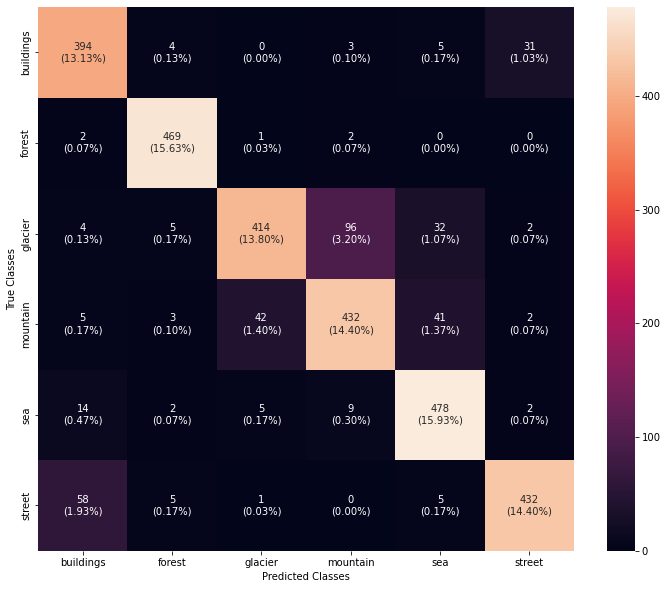

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


labels = {value: key for key, value in train_data.class_indices.items()}


cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="rocket", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.savefig('TransferLearnCF.png')
plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [21]:
train_data.classes = label_binarize(train_data.classes, classes=[0, 1, 2,3,4,5])
n_classes = train_data.classes.shape[1]
print(n_classes)
#random_state = np.random.RandomState(0)

y_train = label_binarize(train_data.classes, classes=[0,1,2,3,4,5])
y_test = label_binarize(test_data.classes, classes=[0,1,2,3,4,5])

6


In [22]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_data.classes==i, y_prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

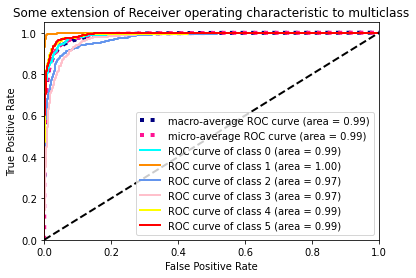

In [23]:
lw = 2 #IDK WHAT THIS IS

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
#plt.plot(
#    fpr["micro"],
#    tpr["micro"],
#

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["green", "darkorange", "cornflowerblue", "purple", "yellow", "red"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.savefig('TransferLearnROC.png')
plt.show()


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.83      0.90      0.86       437
      forest       0.96      0.99      0.98       474
     glacier       0.89      0.75      0.81       553
    mountain       0.80      0.82      0.81       525
         sea       0.85      0.94      0.89       510
      street       0.92      0.86      0.89       501

    accuracy                           0.87      3000
   macro avg       0.88      0.88      0.87      3000
weighted avg       0.88      0.87      0.87      3000



In [1]:
# extracted sensitivity and specificity

FP = cf_mtx.sum(axis=0) - np.diag(cf_mtx)  
FN = cf_mtx.sum(axis=1) - np.diag(cf_mtx)
TP = np.diag(cf_mtx)
TN = cf_mtx.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)

np.set_printoptions(precision = 2)
print('Sensitivity:',TPR ,'\n''Specificity:',TNR)

NameError: name 'cf_mtx' is not defined